<a href="https://colab.research.google.com/github/Sumana18/MSAVI_GEE/blob/main/MSAVI2_Calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Brief Introduction:**

*   The modified soil-adjusted vegetation index (MSAVI) is a vegetation index, which is used to lift limits on applying NDVI to the areas with a high composition of bare soil. 
*   MSAVI is used in the areas where indices like NDVI provide invalid data, mostly due to a small amount of vegetation, or due to a lack of chlorophyll therein. Thus, the index is used to minimize the soil background influence and to increase the dynamic range of vegetation signal.
*   Especially to be used  for analysis of young crops; for arid regions with sparse vegetation (less than 15% of total area) and exposed soil surfaces.
Its ranges form -1 to +1, Higher the value denser the vegetation.

**The formula:**

`MSAVI = (2 * NIR + 1 – sqrt ((2 * NIR + 1)2 – 8 * (NIR - Red))) / 2`


**About the Task:**
*  Coordinates of three locations have been provided, Place1 is located in Punjab, Place 2 is located in UP and Place 3 in Telangana.
*  All of them are located in India
*  MSAVI2 has been calculated for each of this location.
*  The time of analysis is January 2020 to June 2020.
*  The dataset used is LANDSAT8

In [1]:
#Immport and initialize the Google Earth Engine API.
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=isw4iT3JooumOErh1NcSajB5HqvvWSG78pf_MPh_kCI&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g4IYFyw8rNpqbB6EpwjKzbMJBaYnBO2Qtyf-VSpH__kqnFaa2pAu8c

Successfully saved authorization token.


In [108]:
#import required libraries.
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [126]:
#The coordinates of each location converted into polygon feature.
place1 = ee.Geometry.Polygon([[75.45157492160797,30.634404129904425],[75.4524278640747,30.63372099804389],[75.45236885547638,30.634399514164798],[75.45157492160797, 30.634404129904425]])
place2 = ee.Geometry.Polygon([[85.85622847080231, 26.09425078918021], [85.85590660572052, 26.093581136401006],[85.85663080215454, 26.09337879451938], [85.85686147212981, 26.094009907326967], [85.85622847080231, 26.09425078918021]])
place3 = ee.Geometry.Polygon([[78.66571158170699, 17.66869116558751], [78.6662346124649, 17.6686911655875], [78.6662346124649, 17.66929686130703], [78.66571158170699, 17.66929686130703], [78.66571158170699, 17.66869116558751]])

# A function to get and rename bands of interest from OLI.
def rename_oli(img):
  return (img.select(
      ee.List(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'pixel_qa']),
      ee.List(['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'pixel_qa'])))


# A function to mask out clouds and cloud shadows using QA band.
def cfmask(img):
  cloud_shadow_bi_mask = 1 << 3
  cloud_bit_mask = 1 << 5
  qa = img.select('pixel_qa')
  mask = qa.bitwiseAnd(cloud_shadow_bi_mask).eq(0).And(
      qa.bitwiseAnd(cloud_bit_mask).eq(0))
  return img.updateMask(mask)


# A function to calculate MSAVI2.
def calc_msavi2(img):
  return img.expression( '(2 * NIR + 1 - sqrt(pow((2 * NIR + 1), 2) - 8 * (NIR - Red)) ) / 2', 
  {
    'NIR': img.select('NIR'), 
    'Red': img.select('Red')
  }).rename('MSAVI2')

# Function to finally implement all the above functions and prepare OLI images.
def prep_oli(img):
  orig = img
  img = rename_oli(img)
  img = cfmask(img)
  img = calc_msavi2(img)
  img = img.copyProperties(orig, orig.propertyNames())
  return img


# Import image collections for Landsat8  (surface reflectance).
oli_col = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR').filterDate('2020-01-01','2020-6-30')

# Filter collections and prepare
place1_col = oli_col.filterBounds(place1).map(prep_oli)
place2_col = oli_col.filterBounds(place2).map(prep_oli)
place3_col = oli_col.filterBounds(place3).map(prep_oli)


In [ ]:
place1_col.getInfo()   #Metadata

In [128]:
# Function to for reducing pixels intersecting a provided region to a statistic for each image in a collection
def create_reduce_region_function(geometry,reducer,scale,crs):
  def reduce_region_function(img):
    mean = img.reduceRegion(
        reducer=reducer,
        geometry=geometry,
        scale=scale,
        crs=crs)

    return ee.Feature(geometry, mean).set({'date': img.date().format()})
  return reduce_region_function

In [129]:
#calculate Mean for each region
reduced_place1 = create_reduce_region_function(geometry=place1, reducer=ee.Reducer.mean(), scale=30, crs='EPSG:4326')
reduced_place2 = create_reduce_region_function(geometry=place2, reducer=ee.Reducer.mean(), scale=30, crs='EPSG:4326')
reduced_place3 = create_reduce_region_function(geometry=place3, reducer=ee.Reducer.mean(), scale=30, crs='EPSG:4326')

In [130]:
# Filter out features with null computed values
msavi_stat_fc_place1 = ee.FeatureCollection(place1_col.map(reduced_place1)).filter(
    ee.Filter.notNull(place1_col.first().bandNames()))
msavi_stat_fc_place2 = ee.FeatureCollection(place2_col.map(reduced_place2)).filter(
    ee.Filter.notNull(place2_col.first().bandNames()))
msavi_stat_fc_place3 = ee.FeatureCollection(place3_col.map(reduced_place3)).filter(
    ee.Filter.notNull(place3_col.first().bandNames()))

In [131]:
# Function to transfer feature properties to a dictionary
def fc_to_dict(fc):
  prop_names = fc.first().propertyNames()
  prop_lists = fc.reduceColumns(
      reducer=ee.Reducer.toList().repeat(prop_names.size()),
      selectors=prop_names).get('list')

  return ee.Dictionary.fromLists(prop_names, prop_lists)

In [134]:
#converting dictionary to dataframe for Place 1 (Punjab)
msavi_dict_place1 = fc_to_dict(msavi_stat_fc_place1).getInfo()
msavi_df_place1 = pd.DataFrame(msavi_dict_place1)
msavi_df_place1['date'] = pd.to_datetime(msavi_df_place1['date'])
display(msavi_df_place1)

,MSAVI2,date,system:index
0,0.832523,2020-01-23 05:30:57,LC08_148039_20200123
1,0.620982,2020-02-08 05:30:52,LC08_148039_20200208
2,0.545132,2020-02-24 05:30:48,LC08_148039_20200224
3,0.629424,2020-05-30 05:30:17,LC08_148039_20200530
4,0.655755,2020-06-15 05:30:27,LC08_148039_20200615


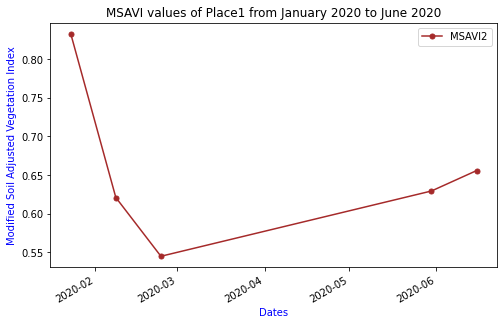

In [135]:
# Time-series plot of MSAVI2 for PLace 1
msavi_df_place1.plot(x='date', y='MSAVI2',marker ='.',markersize=10,color ='Brown',figsize=(8,5),title='MSAVI values of Place1 from January 2020 to June 2020')
plt.xlabel("Dates",color = 'Blue')
plt.ylabel("Modified Soil Adjusted Vegetation Index",color='Blue')
plt.show()

In [136]:
#converting dictionary to dataframe for Place 2 (UP)
msavi_dict_place2 = fc_to_dict(msavi_stat_fc_place2).getInfo()
msavi_df_place2 = pd.DataFrame(msavi_dict_place2)
msavi_df_place2['date'] = pd.to_datetime(msavi_df_place2['date'])
display(msavi_df_place2)

,MSAVI2,date,system:index
0,0.926145,2020-01-31 04:42:39,LC08_140042_20200131
1,0.893803,2020-02-16 04:42:35,LC08_140042_20200216
2,0.862376,2020-03-03 04:42:30,LC08_140042_20200303
3,0.551971,2020-03-19 04:42:23,LC08_140042_20200319
4,0.357871,2020-04-04 04:42:14,LC08_140042_20200404
5,0.925494,2020-02-07 04:48:48,LC08_141042_20200207
6,0.900534,2020-02-23 04:48:44,LC08_141042_20200223
7,0.775629,2020-03-10 04:48:38,LC08_141042_20200310
8,0.449141,2020-03-26 04:48:30,LC08_141042_20200326
9,0.358027,2020-04-11 04:48:22,LC08_141042_20200411


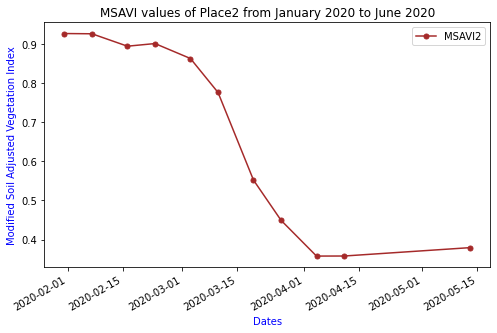

In [137]:
# Time-series plot of MSAVI2 for PLace 2
msavi_df_place2.plot(x='date', y='MSAVI2',marker ='.',markersize=10,color ='Brown',figsize=(8,5),title='MSAVI values of Place2 from January 2020 to June 2020')
plt.xlabel("Dates",color = 'Blue')
plt.ylabel("Modified Soil Adjusted Vegetation Index",color='Blue')
plt.show()

In [138]:
#converting dictionary to dataframe for Place 3 (Telangana)
msavi_dict_place3 = fc_to_dict(msavi_stat_fc_place3).getInfo()
msavi_df_place3 = pd.DataFrame(msavi_dict_place3)
msavi_df_place3['date'] = pd.to_datetime(msavi_df_place3['date'])
display(msavi_df_place3)

,MSAVI2,date,system:index
0,0.805534,2020-01-11 05:09:52,LC08_144048_20200111
1,0.867557,2020-01-27 05:09:47,LC08_144048_20200127
2,0.847248,2020-02-28 05:09:38,LC08_144048_20200228
3,0.851568,2020-03-15 05:09:32,LC08_144048_20200315
4,0.828832,2020-03-31 05:09:22,LC08_144048_20200331
5,0.746895,2020-04-16 05:09:16,LC08_144048_20200416
6,0.753645,2020-05-02 05:09:07,LC08_144048_20200502
7,0.456451,2020-06-03 05:09:11,LC08_144048_20200603


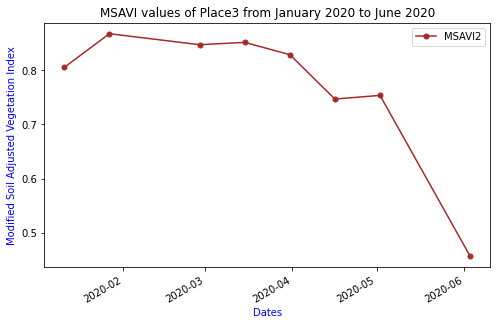

In [139]:
# Time-series plot of MSAVI2 for PLace 3
msavi_df_place3.plot(x='date', y='MSAVI2',marker ='.',markersize=10,color ='Brown',figsize=(8,5),title='MSAVI values of Place3 from January 2020 to June 2020')
plt.xlabel("Dates",color = 'Blue')
plt.ylabel("Modified Soil Adjusted Vegetation Index",color='Blue')
plt.show()

**Observations and conclusions**
* India has two crop seasons, Kharif (monsoon crops, July-October) and Rabi (non-monsoon crops, November - July). The analysis has been done from January to June which means it captures the growth and harvesting period of Rabi crops.

* Place 2 and Place 3 both show higher values in the early months which represents dense vegetation and lower values towards the end.
* The values in Place 2 is recorded least in april, representing completion of harvest
* The values in Place 3 hits lowest in the month of June, marking the presence of bare land due to completion of harvest
* Place 1 shows a little abnormality. Sudden dip is observed in the month of February and then a rising trend till June. Also, due to cloud and cloud shadow masking, number of images recieved are very less making it difficult to draw any kind of conclusions.
